In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Audio

In [2]:
# Sample rate
sr = 22050

In [3]:
# Util functions
def get_dataset(folder):
    X = []
    ys = []
    f = os.path.join('/kaggle/input/preprocess-audio/' ,folder)
    for filename in os.listdir(f):
        try:
            y, _ = librosa.load(os.path.join(f, filename), sr = sr)
            X.append(y)
            ys.append(int(labels.index(folder)))
        except:
            print(folder + "/" + filename)
    return X, ys
def draw_spectrogram(y, n_fft, hop_length, label):
    D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))
    librosa.display.specshow(librosa.amplitude_to_db(D),y_axis='log', x_axis='time')
    plt.title('Power spectrogram (' + label +')')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
def draw_waveplot(y, sr):
    librosa.display.waveplot(y, sr)
    plt.tight_layout()
    plt.show()

In [4]:
labels = ['dog bark', 'say go', 'baby cry']

In [5]:
# Get all data
num_samples = {}
X = []
y = []
for folder in labels:
    X_folder, y_folder = get_dataset(folder)
    X += X_folder
    y += y_folder
    num_samples[folder] = len(X_folder)

baby cry/252.wav
baby cry/253.wav


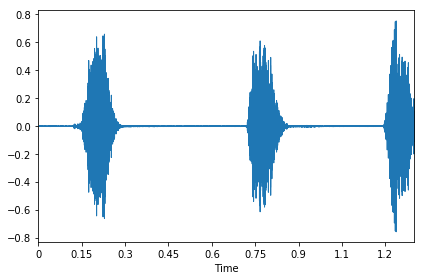

In [6]:
draw_waveplot(X[0], sr)

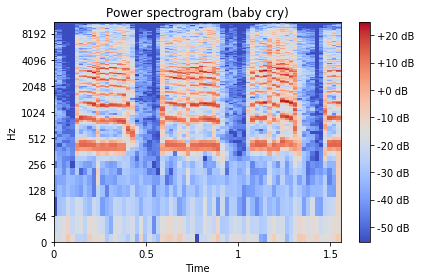

In [7]:
draw_spectrogram(librosa.util.fix_length(X[700], 3 * sr), n_fft = 512, hop_length = 1000, label = labels[y[700]])

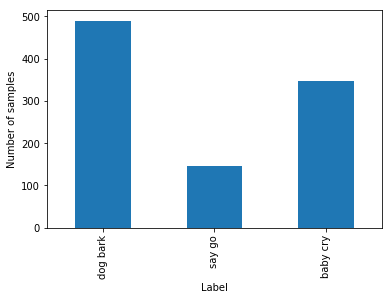

In [8]:
# Number of samples
pd.Series(num_samples).plot.bar()
plt.xlabel("Label")
plt.ylabel("Number of samples");

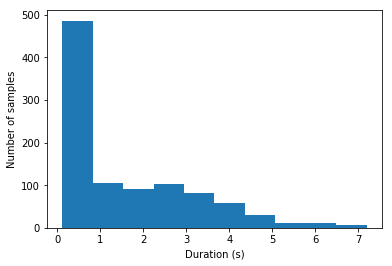

In [9]:
# Length of audios
lengths = [librosa.core.get_duration(s, sr) for s in X]
plt.hist(lengths)
plt.xlabel("Duration (s)")
plt.ylabel("Number of samples")
plt.show()

In [10]:
class FixLength(BaseEstimator, TransformerMixin):
    def __init__(self, length):
        self.length = length * sr
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # X contains tupes of y and sr
        res = []
        for y in X:
            y_fixed = librosa.util.fix_length(y, self.length)
            res.append(y_fixed)
        return res

In [11]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, n_fft = 512, hop_length = 1000):
        self.n_fft = n_fft
        self.hop_length = hop_length
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        res = []
        for y in X:
            y_fft = librosa.amplitude_to_db(np.abs(librosa.core.stft(y, n_fft = self.n_fft, hop_length=self.hop_length))).flatten()
            res.append(y_fft)
        return res

In [12]:
# Train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [13]:
fix_length = FixLength(2)
stft = STFT()
process_pipeline = Pipeline(steps =[("fix_length", fix_length), ("stft", stft)])
model = MLPClassifier(hidden_layer_sizes=(100,50,20,3), activation='tanh', solver='lbfgs', random_state=0, max_iter=500, verbose=1, alpha = 1)
pipeline = Pipeline(steps =[("process", process_pipeline), ("model", model)])

In [14]:
n_ffts = [128, 256, 512, 1024, 2048]
alphas = [100, 10, 1, 0.1, 0.01, 0.001]

val_score = []
train_score = []

for n_fft in n_ffts:
    for alpha in alphas:
        pipeline.set_params(process__stft__n_fft=n_fft, model__alpha=alpha)
        pipeline.fit(X_train, y_train)
        val_score.append(pipeline.score(X_val, y_val))
        train_score.append(pipeline.score(X_train, y_train))

In [15]:
best_score = max(val_score)
index_max = val_score.index(best_score)
best_alpha = alphas[index_max%len(alphas)]
best_nfft = n_ffts[index_max//len(n_ffts)]
print("Best accuracy on validation: " + str(best_score))
print("Best n_fft: " + str(best_nfft))
print("Best alpha: " + str(best_alpha))

Best accuracy on validation: 0.934010152284264
Best n_fft: 512
Best alpha: 10


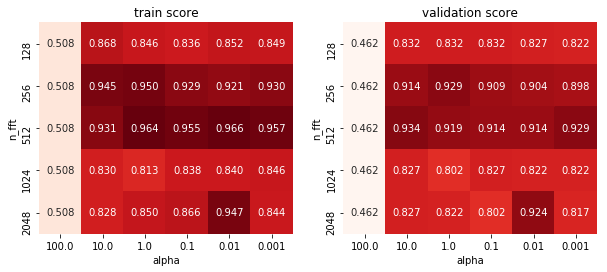

In [16]:
# Visualize results
import seaborn as sns
train_scores_df = pd.DataFrame(data=np.array(train_score).reshape(len(n_ffts), -1),
                             index=n_ffts, columns= alphas)
val_scores_df = pd.DataFrame(data=np.array(val_score).reshape(len(n_ffts), -1), 
                           index= n_ffts, columns= alphas)
min_score = min(min(train_score), min(val_score))
max_score = max(max(train_score), max(val_score))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train score'); plt.ylabel('n_fft'); plt.xlabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_scores_df, vmin=min_score, vmax=max_score, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation score'); plt.ylabel('n_fft'); plt.xlabel('alpha');

# Add noise to validation data

In [17]:
# Set hyperparameters for model which archive best performance
pipeline.set_params(process__stft__n_fft=best_nfft, model__alpha=best_alpha);
pipeline.fit(X_train, y_train);

In [18]:
def add_gaussian_noise(data, amplitude):
    return data + amplitude * np.random.normal(size = data.shape)

In [19]:
def test_with_noise():
    noise_amplitude = np.linspace(0, 1, 50)
    scores = []
    for amplitude in noise_amplitude:
        X_val_noise = [add_gaussian_noise(x,amplitude) for x in X_val]
        scores.append(pipeline.score(X_val_noise, y_val))
    plt.plot(noise_amplitude,scores)
    plt.xlabel("Noise amplitude")
    plt.ylabel("Accuracy")
    plt.show()

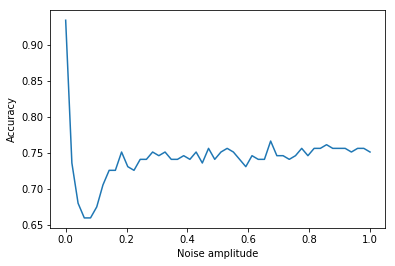

In [20]:
test_with_noise()

# Add augmentation

In [21]:
#Hyperparameters
X_train_augment = X_train.copy()
y_train_augment = y_train.copy()
for i, data in enumerate(X_train):
    # Add noise
    X_train_augment.append(add_gaussian_noise(data, np.random.rand()))
    y_train_augment.append(y_train[i])
    # Pitch shift
    X_train_augment.append(librosa.effects.pitch_shift(data, sr, 2))
    y_train_augment.append(y_train[i])

In [22]:
pipeline.fit(X_train_augment, y_train_augment);

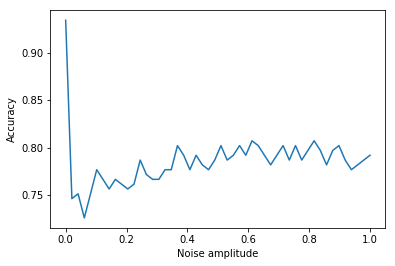

In [23]:
test_with_noise()

In [24]:
# Test on original validation set
pipeline.score(X_val, y_val)

0.934010152284264